In [18]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/Reviews.csv")  # Update path as needed
df = df.dropna(subset=["review"])
df.head()

,review
0,The camera on this phone is truly exceptional.
1,Battery life is a major letdown.
2,The display is incredibly vibrant.
3,Performance is buttery smooth.
4,I love the sleek design.


In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = "cpu"

model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
# PROMPT 1: Feature Extraction
def generate_feature_prompt(review):
    return f"""
      Extract the **product feature** being discussed in the review.

      Examples:
      Review: The camera is amazing.
      Output: camera

      Review: Battery drains quickly.
      Output: battery

      Review: App loading is fast and smooth.
      Output: performance

      Review: {review}
      Output:
      """


In [6]:
def extract_feature_from_review(review):
    prompt = generate_feature_prompt(review)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(**inputs, max_length=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return response

In [7]:
# Step 1: Get the first review
first_review = df['review'].iloc[0]
response = extract_feature_from_review(first_review)

print("Review:", first_review)
print("Extracted Feature:", response)


Review: The camera on this phone is truly exceptional.
Extracted Feature: camera


In [8]:
df['extracted_feature'] = df['review'].apply(extract_feature_from_review)

In [9]:
def generate_sentiment_prompt(review, feature):
    return f"""
Classify the sentiment (positive, negative, or neutral) toward the feature: **{feature}** in the review.

Examples:
Review: The camera is amazing.
Feature: camera
Sentiment: positive

Review: Battery drains quickly.
Feature: battery
Sentiment: negative

Review: The device is okay.
Feature: design
Sentiment: neutral

Review: {review}
Feature: {feature}
Sentiment:
"""

In [10]:
def extract_sentiment_from_review(review,feature):
    prompt = generate_sentiment_prompt(review, feature)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(**inputs, max_length=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return response

In [11]:
first_review = df['review'].iloc[0]
first_feature = df['extracted_feature'].iloc[0]
response = extract_sentiment_from_review(first_review, first_feature)

print("Review:", first_review)
print("Extracted Feature:", first_feature)
print("Extracted Sentiment:", response)

Review: The camera on this phone is truly exceptional.
Extracted Feature: camera
Extracted Sentiment: positive


In [12]:
sentiments = []

for review, feature in zip(df['review'], df['extracted_feature']):
    sentiment = extract_sentiment_from_review(review, feature)
    sentiments.append(sentiment)

df['sentiment'] = sentiments

In [13]:
df.to_csv("extracted_features_with_sentiment.csv", index=False)

In [17]:
df.head(5)

,review,extracted_feature,sentiment
0,The camera on this phone is truly exceptional.,camera,positive
1,Battery life is a major letdown.,battery,negative
2,The display is incredibly vibrant.,display,positive
3,Performance is buttery smooth.,performance,positive
4,I love the sleek design.,sleek design,positive


In [15]:
# Summarize Most/Least Appreciated Features
# -----------------------------
feature_sentiments = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0})

for _, row in df.iterrows():
    feature = row['extracted_feature'].strip().lower()
    sentiment = row['sentiment'].strip().lower()
    if sentiment in ['positive', 'negative', 'neutral']:
        feature_sentiments[feature][sentiment] += 1

summary_df = pd.DataFrame([
    {
        'feature': feature,
        'positive_mentions': counts['positive'],
        'negative_mentions': counts['negative'],
        'neutral_mentions': counts['neutral']
    }
    for feature, counts in feature_sentiments.items()
])

summary_df = summary_df.sort_values(by='positive_mentions', ascending=False)
summary_df.to_csv("feature_sentiment_summary.csv", index=False)

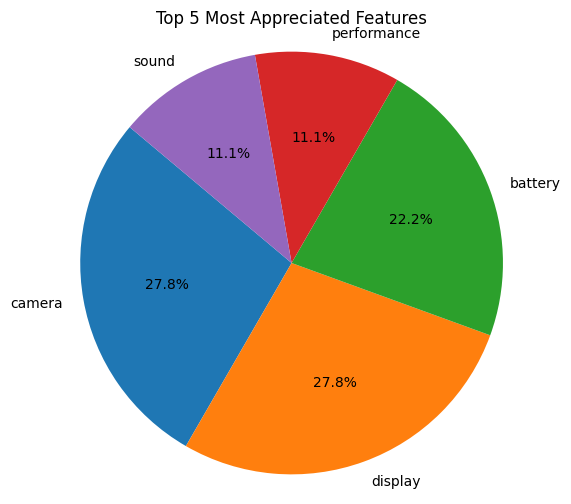

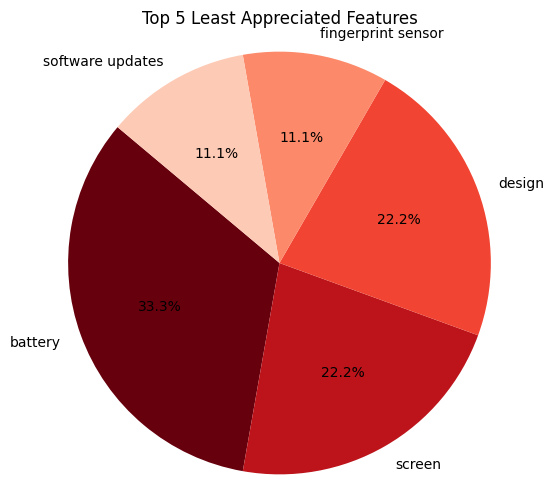

In [16]:
# Visualization (Pie Charts)
# -----------------------------
# Top 5 most appreciated
top_pos = summary_df.sort_values(by='positive_mentions', ascending=False).head(5)
plt.figure(figsize=(6, 6))
plt.pie(top_pos['positive_mentions'], labels=top_pos['feature'], autopct='%1.1f%%', startangle=140)
plt.title("Top 5 Most Appreciated Features")
plt.axis('equal')
plt.show()

# Top 5 least appreciated
top_neg = summary_df.sort_values(by='negative_mentions', ascending=False).head(5)
colors = [plt.cm.Reds_r(i / 5) for i in range(5)]
plt.figure(figsize=(6, 6))
plt.pie(top_neg['negative_mentions'], labels=top_neg['feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Top 5 Least Appreciated Features")
plt.axis('equal')
plt.show()

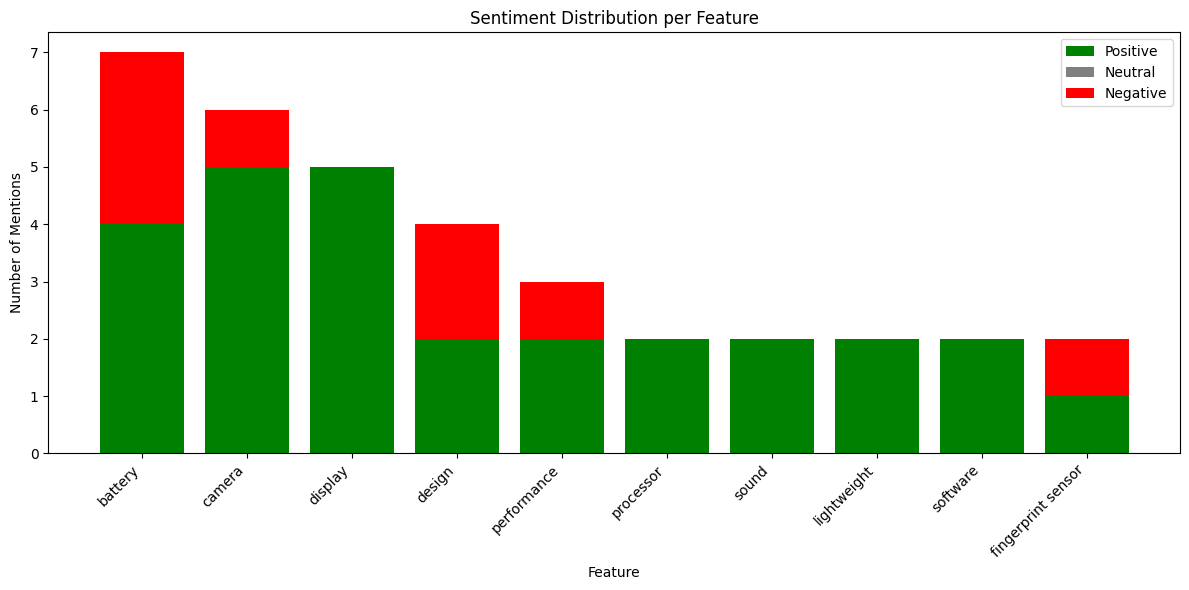

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

summary_df = pd.read_csv("feature_sentiment_summary.csv")

# Top 10 features by total mentions
summary_df['total_mentions'] = summary_df[['positive_mentions', 'negative_mentions', 'neutral_mentions']].sum(axis=1)
top_features = summary_df.sort_values(by='total_mentions', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))

# Bar positions
features = top_features['feature']
pos = top_features['positive_mentions']
neg = top_features['negative_mentions']
neu = top_features['neutral_mentions']

# Stacked bar chart
plt.bar(features, pos, label='Positive', color='green')
plt.bar(features, neu, bottom=pos, label='Neutral', color='gray')
plt.bar(features, neg, bottom=pos+neu, label='Negative', color='red')

plt.xticks(rotation=45, ha='right')
plt.title("Sentiment Distribution per Feature")
plt.ylabel("Number of Mentions")
plt.xlabel("Feature")
plt.legend()
plt.tight_layout()
plt.show()
